# EDA

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from src import EDA
%load_ext autoreload
%autoreload 2

import pyspark
from pyspark.sql import SparkSession
spark_session = SparkSession.builder.getOrCreate()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
test_df = spark_session.read.json("../data/steam-800k.jsonl", mode='DROPMALFORMED')
steam_df = test_df.toPandas()
test_df = None

In [7]:
total_hours_played = steam_df['playtime_forever'].sum()
print('Total hours played: ', total_hours_played)
print('Number of records: ', steam_df.shape[0])
print('Number of users: ', steam_df.groupby('user_id').count().shape[0])
steam_df.head()

Total hours played:  988475863
Number of records:  779602
Number of users:  23937


,game_id,playtime_forever,user_id
0,10180,496,76561198016150869
1,10190,0,76561198016150869
2,25800,11756,76561198016150869
3,72850,24052,76561198016150869
4,202710,2409,76561198016150869


#### Remove Extreme Low and High playtimes

## What is the distribution of Hours Played for games?

In [9]:
# remove low high data so that we can see a more granular distribution
# we want to keep the high playtime data for actual analysis
over_1000 = steam_df[steam_df['playtime_forever'] > 1000].shape[0]
at_1 = steam_df[steam_df['playtime_forever'] == 1].shape[0]
print('User purchased but did not play: ', at_1)
print('Dropping ', over_1000 + at_1)
steam_df_no_outliers = steam_df[(steam_df['playtime_forever'] <= 1000) & (steam_df['playtime_forever'] > 1)]

User purchased but did not play:  14388
Dropping  123433


Average hours played:  1267.9237136384977


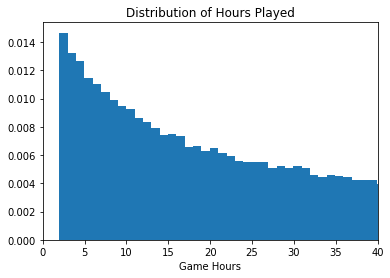

In [12]:
print('Average hours played: ', steam_df['playtime_forever'].mean())
ax, fig = plt.subplots()
fig.hist(steam_df_no_outliers['playtime_forever'], bins=1000, normed=True)
fig.set_xlim(0, 40)
fig.set_title('Distribution of Hours Played')
fig.set_xlabel('Game Hours')
ax.show()

## The Percent of Users who have played many games is low
#### But users need to have played a significant number of games before we can recommend anything

Number of unique users:  23937


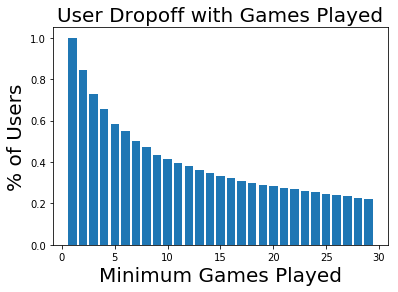

In [21]:
game_counts = steam_df.groupby('user_id').count()
print('Number of unique users: ', game_counts.shape[0])

range_max = 30
counts = [game_counts[game_counts['game_id'] >= i].shape[0] for i in range (1, range_max)]
percent_counts = [count / counts[0] for count in counts]

fig, ax = plt.subplots()
ax.bar(list(range(1, range_max)), percent_counts)
ax.set_title('User Dropoff with Games Played', fontsize=20)
ax.set_xlabel('Minimum Games Played', fontsize=20)
ax.set_ylabel('% of Users', fontsize=20)
fig.show()
fig.savefig('../figures/user_dropoff_big.png')

## Restrict analysis to users with n games played
### n is 5 here

In [16]:
# fig, ax = plt.subplots()
# ax.bar(list(range(1, range_max)), percent_counts)
# ax.set_title('User Dropoff with Games Played')
# ax.set_xlabel('Games Played')
# ax.set_ylabel('% of Users')
# ax.axhline(percent_counts, color='black', linestyle=':')
# fig.show()
# fig.savefig('../figures/user_dropoff_5.png')

In [19]:
no_cold_start_df = EDA.load_200k_restrict_data(5)
user_count = no_cold_start_df.groupby('uid').count().shape[0]
print('Record count: ', no_cold_start_df.shape[0])
print('User count: ', user_count)

Record count:  57789
User count:  2436


In [109]:
# add_summaries has been moved to PandasALSPreprocessor
final = EDA.add_summaries(no_cold_start_df)
final.head(4)

,uid,game_name,purchase_action,playtime,playtime_mean,playtime_min,playtime_max,game_counts,min_max
1,151603712,The Elder Scrolls V Skyrim,play,273.0,105.721530,0.1,1986.0,562,0.549675
3,151603712,Fallout 4,play,87.0,65.274172,0.2,629.0,151,0.552163
5,151603712,Spore,play,14.9,26.016667,0.1,417.0,54,0.142000
7,151603712,Fallout New Vegas,play,12.1,52.247843,0.1,417.0,255,0.115136


## Game cutoff with Users

Number of unique games:  3600


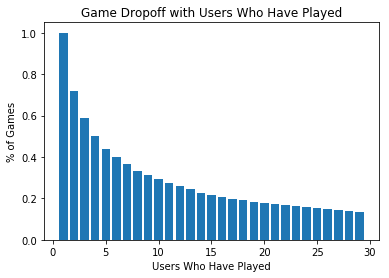

In [10]:
user_counts = steam_df.groupby('game_name').count()
print('Number of unique games: ', user_counts.shape[0])

range_max = 30
counts = [user_counts[user_counts['uid'] >= i].shape[0] for i in range (1, range_max)]
percent_counts = [count / counts[0] for count in counts]

fig, ax = plt.subplots()
ax.bar(list(range(1, range_max)), percent_counts)
ax.set_title('Game Dropoff with Users Who Have Played')
ax.set_xlabel('Users Who Have Played')
ax.set_ylabel('% of Games')
fig.show()
fig.savefig('../figures/game_dropoff.png')

# Goal:

## Provide value to users who have already played a few games